In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg
import cairosvg
from PIL import Image

import matplotlib as mpl
mpl.rcParams["image.interpolation"] = 'none'

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

# Get data

In [3]:
#pull these from hdf5
s_df3 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df3')
s_df6 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df6')
s_df7 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df7')
s_df13 = pd.read_hdf('Data/Fig2_3_S3.hdf5', 's_df13')


# Prepare for Clustering

In [4]:
s_df_xz = pd.concat([s_df3, s_df6, s_df7, s_df13])

In [5]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[50:-50,12:19]
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [6]:
#flattening the other way too
splines = np.asarray(s_df_xz['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

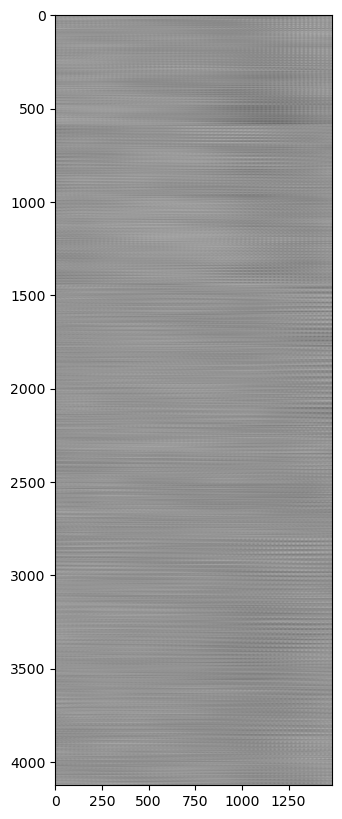

In [7]:
fig = plt.figure(figsize=(10,10))
plt.imshow(spline_array_cropped, cmap='Greys_r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"spline_array_cropped.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [8]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

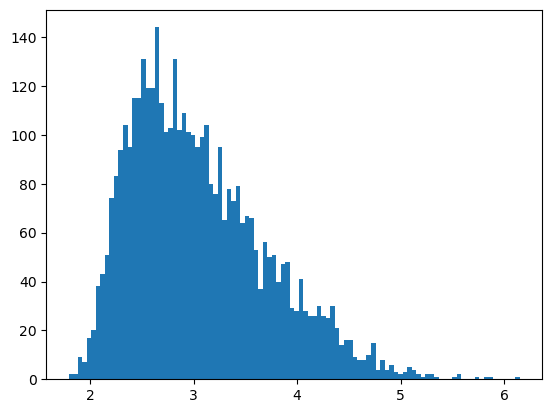

In [9]:
plt.hist(np.amax(np.abs(zscored_spline_array), axis=1), bins=100)
plt.show()

In [10]:
threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

In [11]:
s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

# Clustering

In [12]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig2_3_S3.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments_with_ipl = np.array(f1['cluster_assignments'])
cluster_assignments = np.array(f1['cluster_assignments_no_ipl'])
f1.close()

In [13]:
s_df_xz_masked['new_cluster_assignment'] = cluster_assignments
s_df_xz_masked['old_cluster_assignment'] = cluster_assignments_with_ipl

# Evaluating Clustering and measuring cluster parameters

In [14]:
#make average filters
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

average_filters = np.zeros((s_df_xz_masked['shifted_filters'].iloc[0].shape[0], s_df_xz_masked['shifted_filters'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters']), axis=2)
    average_filters[:,:,i] = current_mean
    

#make SD of filters
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

sd_filters = np.zeros((s_df_xz_masked['shifted_filters'].iloc[0].shape[0], s_df_xz_masked['shifted_filters'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters']), axis=2)
    sd_filters[:,:,i] = current_sd

C:\Users\alv5645\Anaconda3\envs\bcmotion\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\alv5645\Anaconda3\envs\bcmotion\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [15]:
# find the cluster average depth
s_df_xz_copy = s_df_xz_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['depth'].groupby(['new_cluster_assignment']).mean()

# get the IPL depth order for plotting
original_clusters = cluster_avg_depth.index
ipl_depth_order = cluster_avg_depth.sort_values().index

s_df_xz_masked['new_cluster_assignment_sorted'] = s_df_xz_masked['new_cluster_assignment'].replace(
    original_clusters, ipl_depth_order)

# ding et al Chat bands (fig 2):
#means are similar to ZZ's paper but the range is larger.
off_top = 0.80
off_bottom = 0.65
off_mean = (off_top+off_bottom)/2

on_top = 0.25
on_bottom = 0.40
on_mean = (on_top+on_bottom)/2

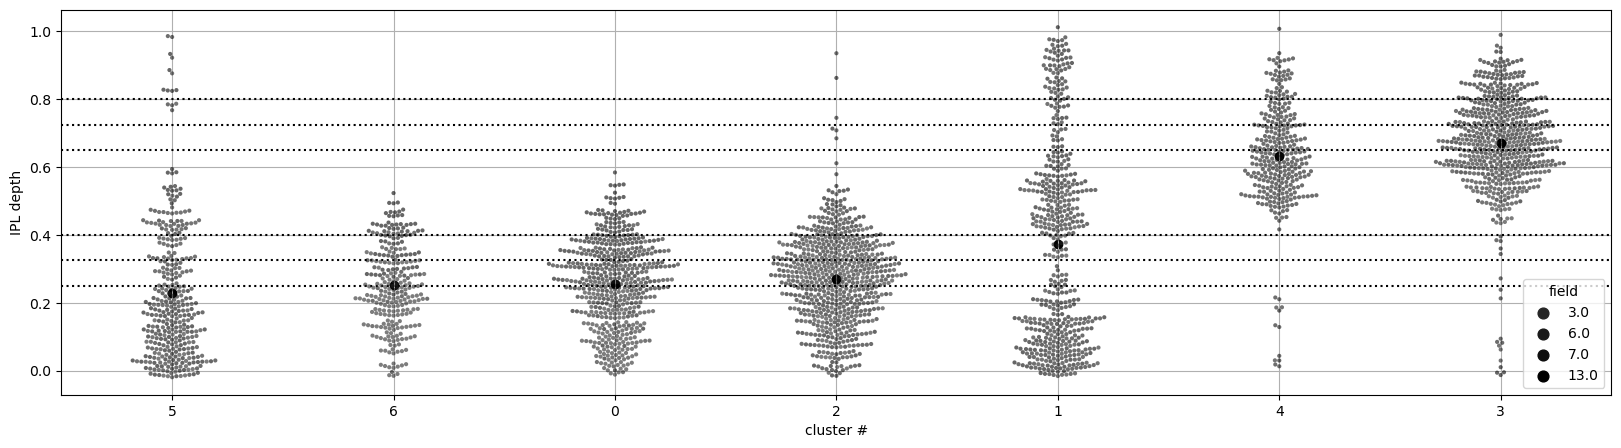

In [16]:
#plot clusters by IPL depth
n_bins = 12
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,5))


ax = sns.swarmplot(data=s_df_xz_masked, x="new_cluster_assignment", y="depth", hue="field",
                   alpha=0.6, color='k', size=3, order=ipl_depth_order)#cmap=cm,hue="field",
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)color='k',
# plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth[ipl_depth_order], color='k')

axes = plt.gca()
axes.axhline(on_top, linestyle='dotted', color='k')
axes.axhline(on_bottom, linestyle='dotted', color='k')
axes.axhline(on_mean, linestyle='dotted', color='k')
axes.axhline(off_top, linestyle='dotted', color='k')
axes.axhline(off_bottom, linestyle='dotted', color='k')
axes.axhline(off_mean, linestyle='dotted', color='k')
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat_woIPL_7clusters.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

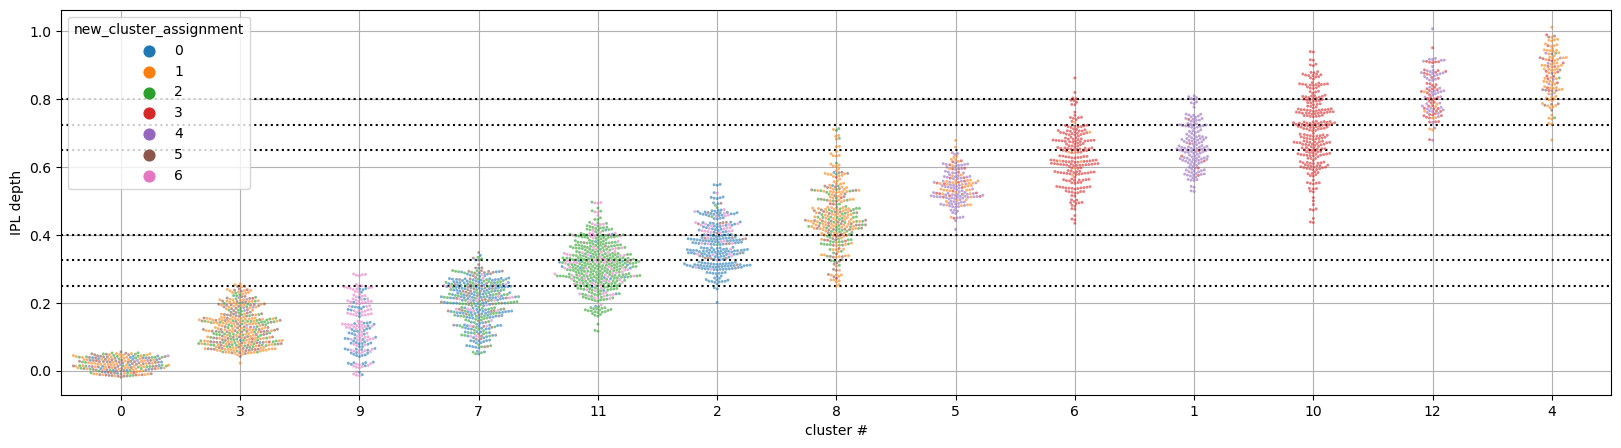

In [17]:
#plot clusters by IPL depth
n_bins = 12
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,5))

#from original clustering
ipl_depth_order_old = np.array([0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4])
ax = sns.swarmplot(data=s_df_xz_masked, x="old_cluster_assignment", y="depth", hue="new_cluster_assignment",
                   alpha=0.6, cmap=cm, size=2.1, order=ipl_depth_order_old)#cmap=cm,hue="field",
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)color='k',
# plt.colorbar()
# plt.scatter(cluster_avg_depth.index, cluster_avg_depth[ipl_depth_order], color='k')

axes = plt.gca()
axes.axhline(on_top, linestyle='dotted', color='k')
axes.axhline(on_bottom, linestyle='dotted', color='k')
axes.axhline(on_mean, linestyle='dotted', color='k')
axes.axhline(off_top, linestyle='dotted', color='k')
axes.axhline(off_bottom, linestyle='dotted', color='k')
axes.axhline(off_mean, linestyle='dotted', color='k')
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat_woIPL.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

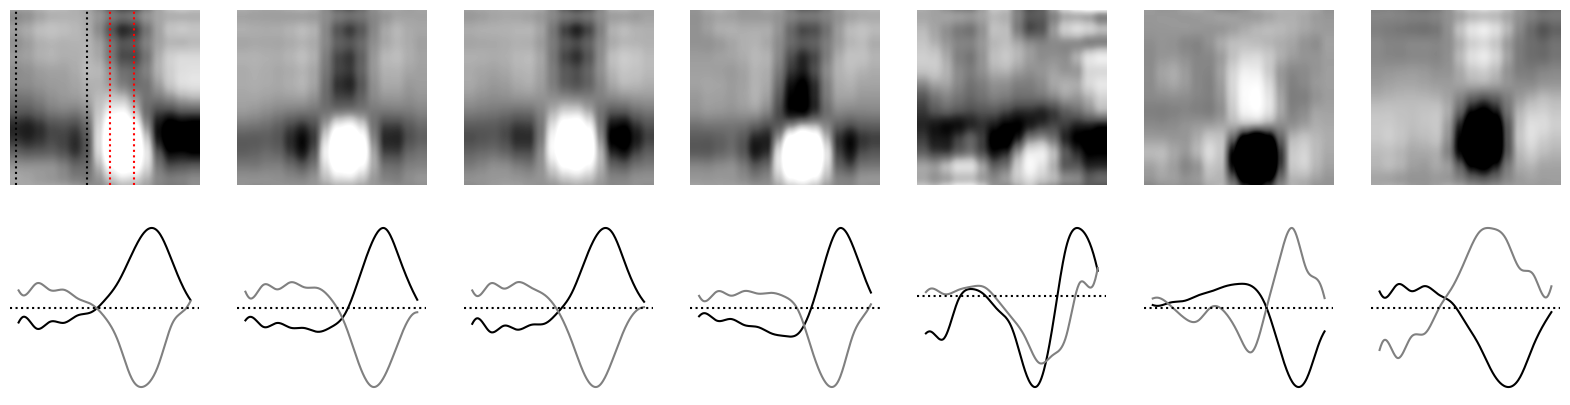

In [18]:
#plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

# polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
polarity = [1, 1, 1, -1, -1, 1, 1, ]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))
fig, ax = plt.subplots(2, 7, figsize=(20, 5))
for i, clust in enumerate(ipl_depth_order):
    
#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
#     ax[0, i].set_yticklabels([])
#     ax[0, i].set_xticklabels([])
#     ax[0, i].axis('off')
    
    ax[0, i].imshow(average_filters[15:-15,10:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
    if i == 0:
        ax[0, i].axvline(10-10, color='k', linestyle='dotted')
        ax[0, i].axvline(16-10, color='k', linestyle='dotted')
        ax[0, i].axvline(18-10, color='r', linestyle='dotted')
        ax[0, i].axvline(20-10, color='r', linestyle='dotted')
    ax[0, i].axis('off')
    
    avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[1, i].axhline(color='k', linestyle='dotted')
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticklabels([])
    ax[1, i].axis('off')
    
#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     plt.show()
    center = np.mean(avg_filter_flipped[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
    surround = np.mean(avg_filter_flipped[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
    latency[clust] = np.argmax(center)-np.argmax(surround) 
    surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[100:280,18:21], axis=1))

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs_woIPL.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

# DSI and RF features

In [19]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [20]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/Fig2_3_S3.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']

array([-0.11970281, -0.03151777, -0.21403457, -0.10724128, -0.02437352,
        0.01293096, -0.21418874])

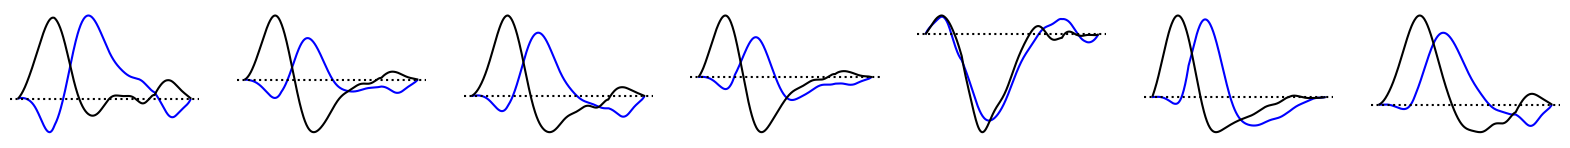

In [21]:
# Get response predictions for 1000 um/s for display

# get the stimulus for convolution

convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(7)
dsi_off = np.zeros(7)

fig, ax = plt.subplots(1, 7, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,:,clust]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')


dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all

# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_half_woIPL.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

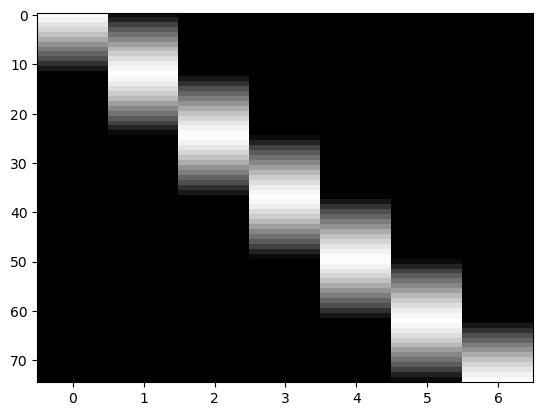

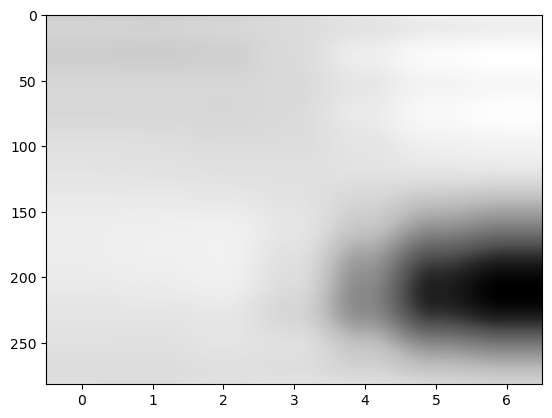

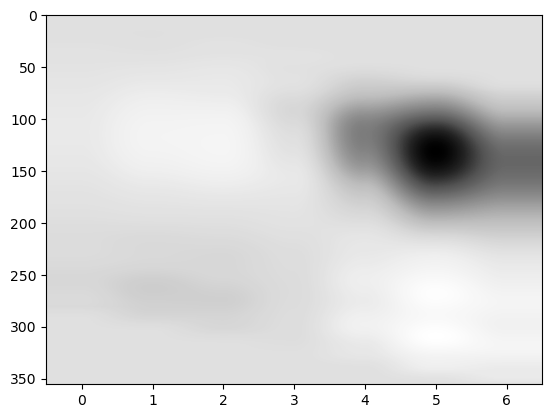

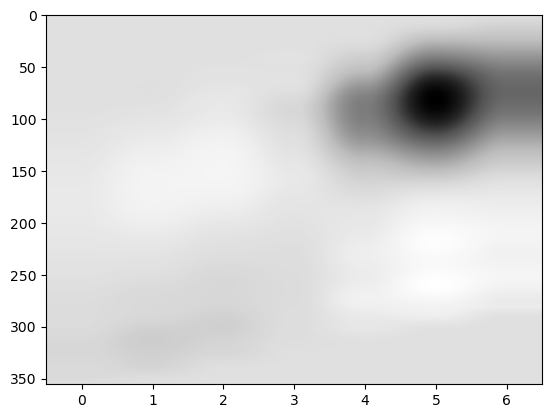

In [22]:
#checking modeling outputs

#plot of the stimulus
fig = plt.figure()
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_off.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

#plot of cut RF
fig = plt.figure()
plt.imshow(spline_cut, cmap='Greys_r', aspect='auto')

#plots of the convolved responses
fig = plt.figure()
plt.imshow(convolved_response, cmap='Greys_r', aspect='auto')

fig = plt.figure()
plt.imshow(convolved_response_rev, cmap='Greys_r', aspect='auto')

In [23]:
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')

s_per_pixel = real_time_lag/time_points

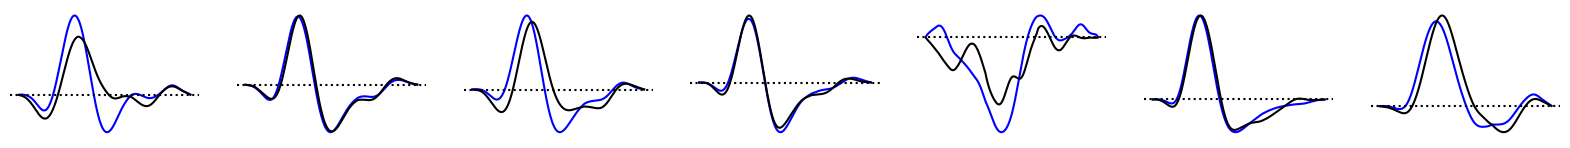

In [24]:
#convolution across whole RF, one velocity

# convolution_stim_params_id = 'convolution_stim_params_id = 2'
# field = field3

# convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 260
convolution_params['distance_covered'] = 260
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
# space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))


#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 7, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:, 13:26, clust] #average_filters[:,4:24,clust]
    edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_full_woIPL.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

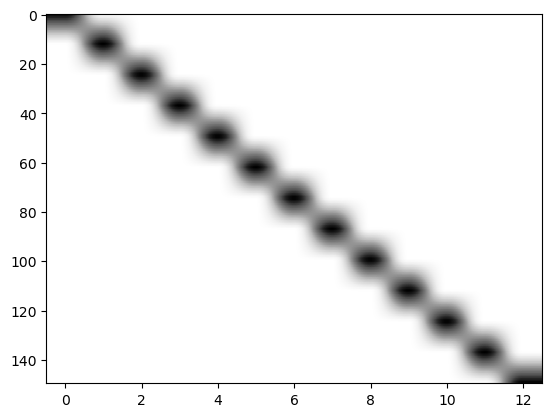

In [25]:
#stimulus image
plt.imshow(stimulus_image*-1, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_full_off.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Velocity tuning

In [26]:
def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(7)
    dsi_off = np.zeros(7)

    fig, ax = plt.subplots(1, 7, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

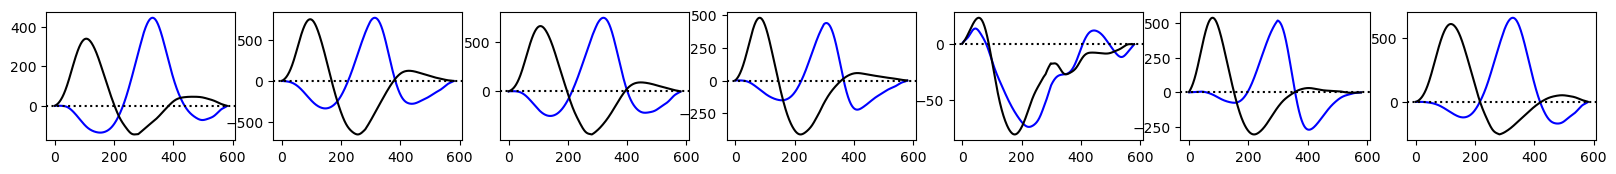

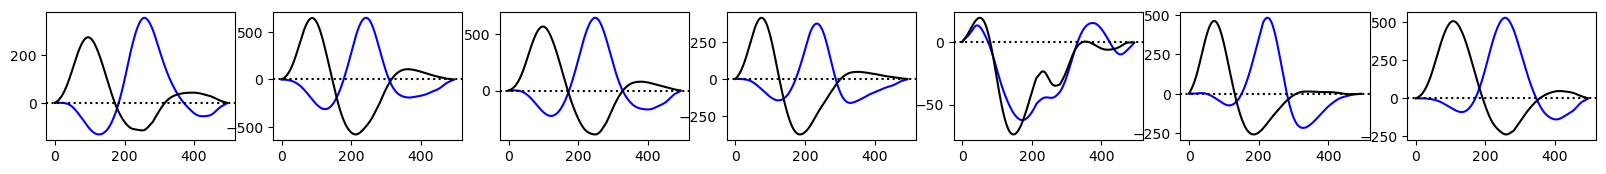

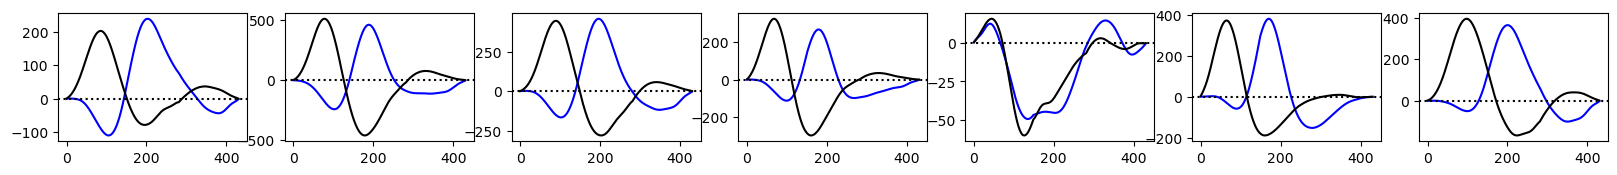

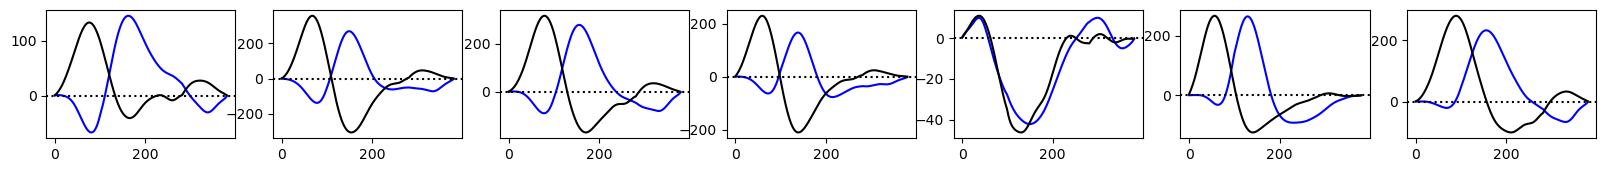

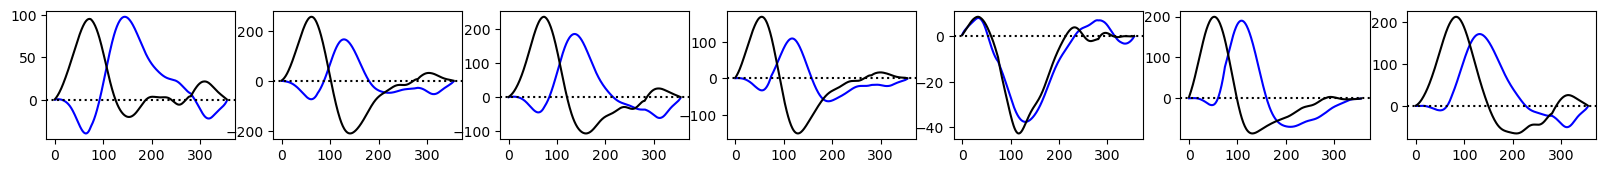

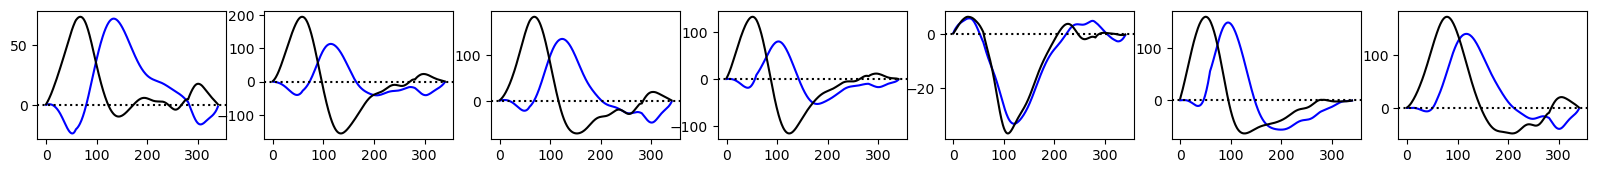

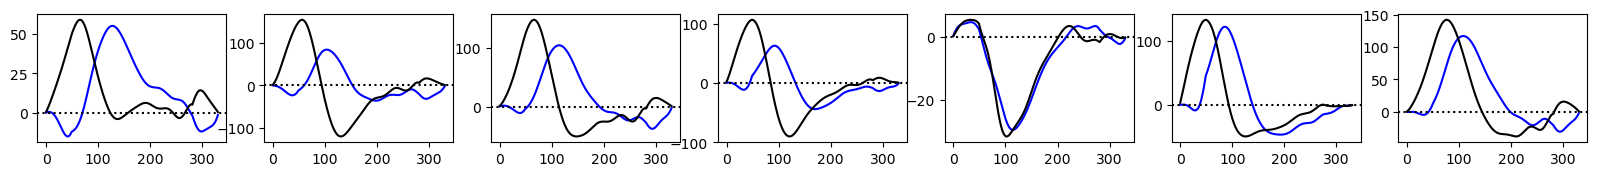

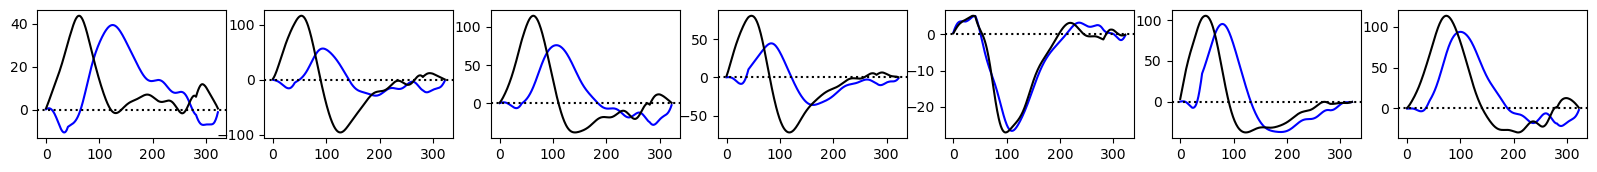

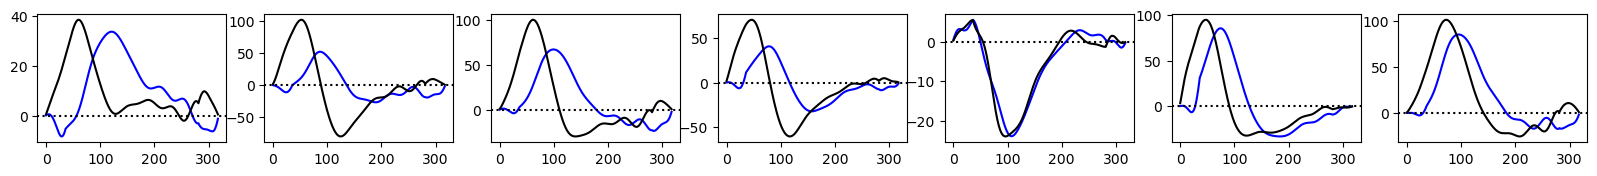

In [27]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all = np.zeros((len(velocities), 7))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params)
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [28]:
def convolved_dsis_centered(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 180 #av updated in revision 2
    convolution_params['distance_covered'] = 180
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(7)
    dsi_off = np.zeros(7)

    fig, ax = plt.subplots(1, 7, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,15:24,clust]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

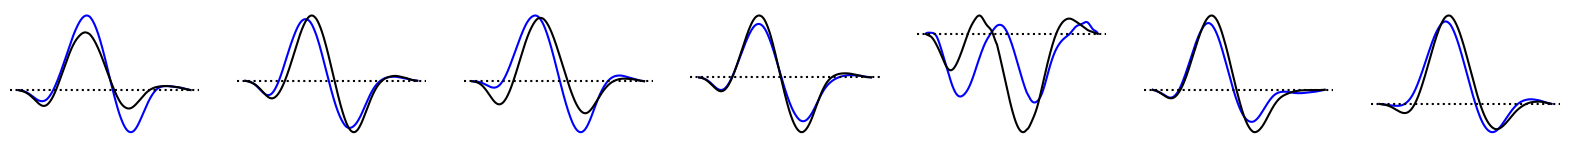

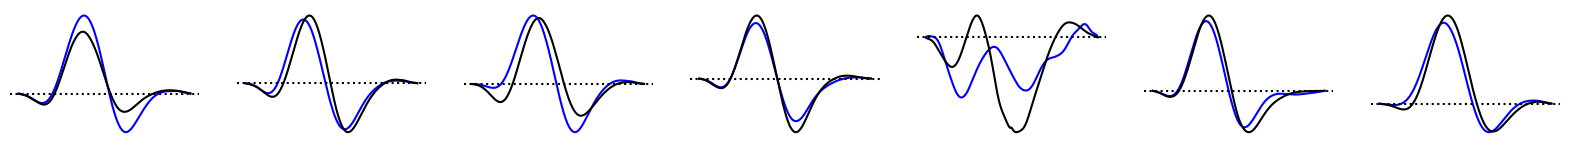

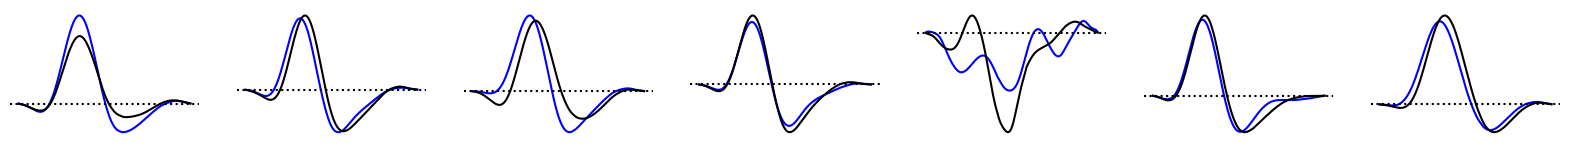

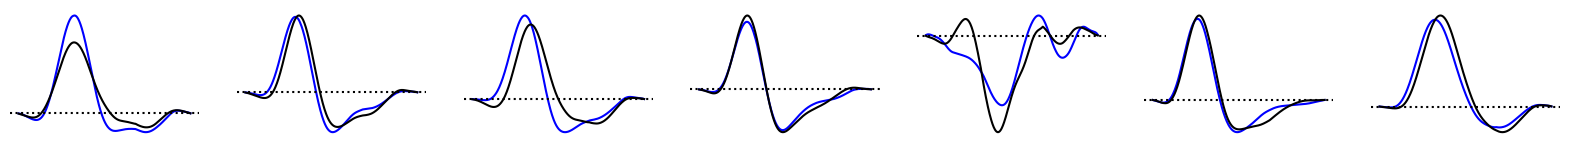

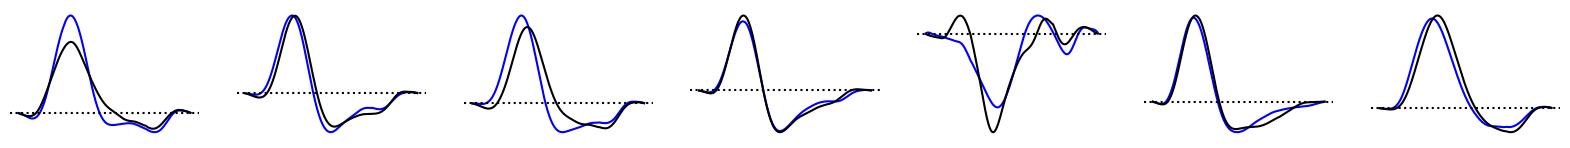

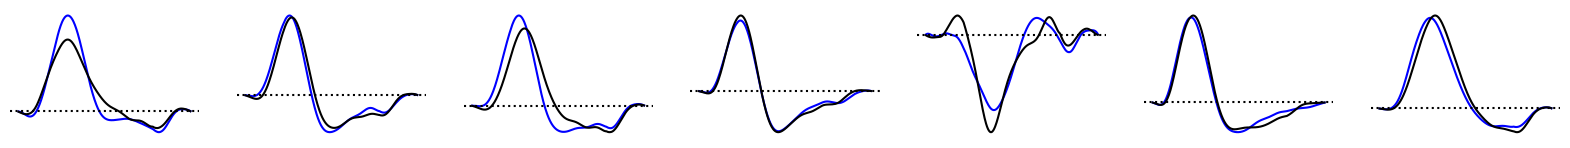

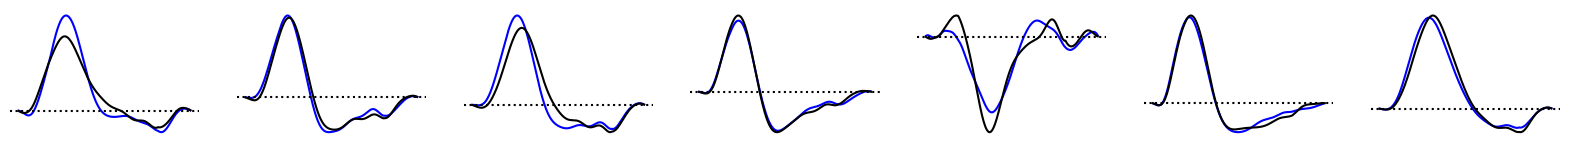

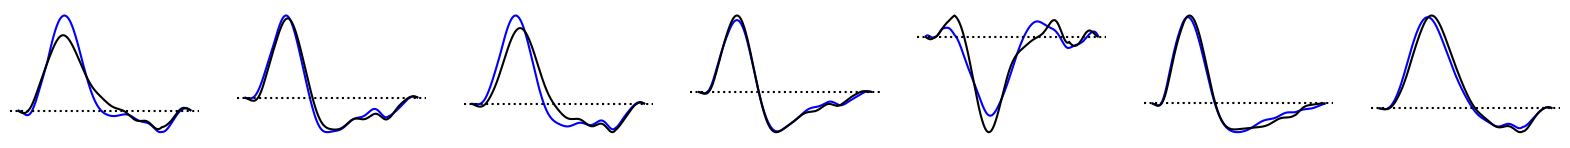

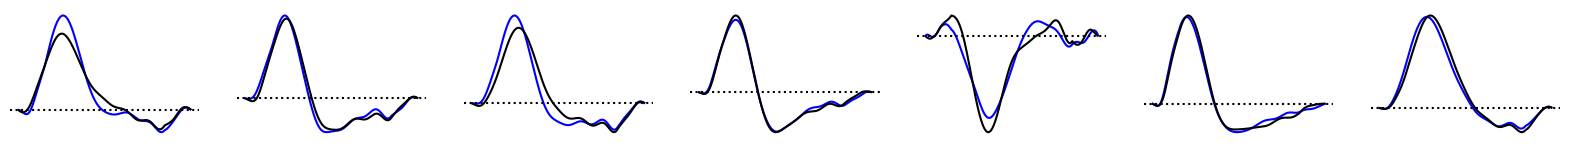

In [29]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 7))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
    dsi_all_all_centered[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

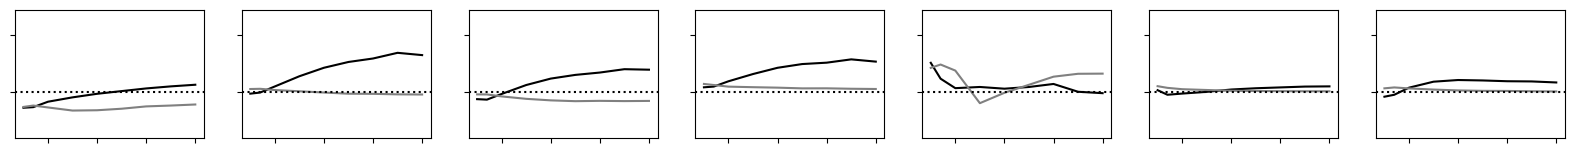

In [30]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 7, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='grey')
    ax[i].set_ylim([-.4, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both_woIPL.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()